In [1]:
import sys
import datetime
import tempfile
import re
import math
import json
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
from easyocr import Reader
import cv2
from PIL import Image
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

In [2]:
cv2.__version__

'4.5.4'

In [3]:
pytesseract.get_tesseract_version() 
# pytesseract.__version__

<Version('4.1.1')>

- x = xmin
- y = ymin
- w = xmax - xmin
- h = ymax - ymin

- cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),15)

In [4]:
def plt_imshow(title='image', img=None, figsize=(20 ,10)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [5]:
def crop_image(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            x, y, w, h = cv2.boundingRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
        # show the contour (outline) of the piece of paper
        # print ("Find rectangle contour",rot_rect)
        # print ("x, y, w, h ",x, y, w, h )
        # print ("screenCnt ",screenCnt )
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 2)
        
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, screenCnt.reshape(4, 2) * ratio)
#         crop_img = image_bgr[y:y + h, x:x + w]
        crop_success = True

    return crop_success, crop_img


# flg, crop_image = crop_image(image)
# # plt_imshow("문서외곽선인식", edge_detection(image))
# if flg:
#     plt_imshow(['original', 'croped image'], [image, crop_image])

# # cv2.imwrite('../output/수출면장-PDF-img24-crop.jpg', crop_image)


In [6]:
def crop_image1(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 수출입문서 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)
    ## (2) Find the max-area contour
    # contours를 찾아 크기순으로 정렬
    # cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    receiptCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.1 * peri, True)

        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
        if len(approx) == 4:
            receiptCnt = approx
            break


    # 만약 추출한 윤곽이 없을 경우 오류
    if receiptCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
#         print("before boundingBox",receiptCnt )
#         print("approx[1][0]:",receiptCnt[1][0] )
#         print("approx[2][0]:",receiptCnt[2][0] )
#         print("approx[3][0]:",receiptCnt[3][0] )
#         print("approx[0][0][1]:",receiptCnt[0][0][1] )
        # x1,y1의 좌표를 변형하여 4곡지점 다각형에서 직사각형을 만드는 시도 
        receiptCnt[0][0][0] = receiptCnt[1][0][0]
        receiptCnt[0][0][1] = receiptCnt[1][0][1]
        receiptCnt[1][0][0] = receiptCnt[2][0][0]
        receiptCnt[2][0][1] = receiptCnt[3][0][1]
        receiptCnt[3][0][0] = receiptCnt[0][0][0]
#         print("after boundingBox",receiptCnt )

        x, y, w, h = cv2.boundingRect(receiptCnt)
        print("receiptCnt x, y, w, h",x, y, w, h )
        # x, y값을 보정하여 정사각형으로 변환 [y+44:y+h, x+21:x+w]
        draw_image = image.copy()
        cv2.drawContours(draw_image, [receiptCnt], -1, (0, 255, 0), 2)
#         plt_imshow('finded contour', draw_image)
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
        # crop_img = image_bgr[y+44:y+h, x+21:x+w]
        crop_success = True


    return crop_success, crop_img


# flg, crop_image = crop_image1(image)
# # plt_imshow("문서외곽선인식", edge_detection(image))
# if flg:
#     plt_imshow(['original', 'croped image'], [image, crop_image])

In [7]:
def text_detection(image_bgr, bboxes=None):
    """
    이미지를 입력받아 문자가 있는 영역을 인식하고 잘라내어 list객체로 리턴한다.
    """
    detected_text_area = []
    for orig_box in bboxes:
        # get rotated rectangle from contour
#         rot_rect = cv2.minAreaRect(orig_box)
#         print("orig_box",orig_box)
        x, y, w, h = cv2.boundingRect(orig_box)
        text_area_img = image_bgr[y:y + h, x:x + w]
        detected_text_area.append(text_area_img)
        
    return bboxes, detected_text_area

In [8]:
#텍스트 정제(전처리)
def cleanText(readData):
    #스팸 메세지에 포함되어 있는 특수 문자 제거
#     text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    text = re.sub('[=+#/\?:^$.@*\"※~&%ㆍ!』\\‘|\[\]\<\>`\'…》]}', '', readData)
    #양쪽(위,아래)줄바꿈 제거
    text = text.rstrip('\n')
    text = text.rstrip('\r')
    text = text.rstrip('\r\n')
    text = text.rstrip()
    #양쪽(위,아래)스페이스 제거
    text = text.strip()
    #글자 중간에 있는 스페이스 제거
#     text = text.replace(' ', '')
    return text

In [9]:
#OCR 엔진을 이용해서 수출입신고서 템플릿 JSON과 문자 인식 대상 이미지를 입력으로 인식결과 JSON파일을 리턴한다.
def recognize_text(image_file, json_file):
    """
    OCR 엔진을 이용해서 사업자등록증 템플릿 JSON과 문자 인식 대상 이미지를 입력으로 인식결과 JSON파일을 리턴한다.
    """
    # 주어진 file path 의 이미지 파일을 칼러 파일 BGR타입으로 읽어들인다.
    org_image = cv2.imread(image_file)
    draw_image = org_image.copy()


    bboxes = []
    # 템플릿 JSON파일을 읽는다
    with open(json_file, 'r') as openfile:
        # Reading from json file 
        json_object = json.load(openfile) 

    # 템플릿 JSON파일에서 레이블별로 문자를 인식할 대상 영역정보(좌표)을 읽는다
    for data in json_object['meta']['annotations']:
        # python의 list객체를 numpy의 array type으로 변환
        # bboxes = np.array(bboxes)
        bboxes.append(np.array(data['boundingBox']))
        

    # 읽어 들인 파일의 양식(수출입신고서 등)의 외곽선을 감지하여 잘라낸다.
    flg1 = False
    flg2 = False
    
    flg1, change_image = crop_image(org_image)
    
    if flg1:
        print("change_image 이미지 shape :",change_image.shape)
    else:
        flg2, change_image = crop_image1(org_image)
        if flg2:
            print("change_image 이미지 shape :",change_image.shape)
        else:
            return bboxes, org_image, json_object
    

    

    # 레이블별로 문자를 인식할 대상 영역정보(좌표)와 이미지 정보를 입력하고 
    # 인식대상 문자가 포함된 잘라낸 이미지 list 객체와 좌표정보를 되돌려 받는다.
    # 좌표정보를 주지 않으면 이미지에서 인식 가능한 문자가 포함된 모든 영역 좌표 정보를 되돌려 준다.
    bboxes, text_image_list = text_detection(change_image, bboxes)


    # 이미지 크기를 (420, 540, 0)의 shape 정보를 이용하여 JSON에 입력
    height, width, _ = change_image.shape
    json_object['meta']['imageSize']['height'] = height
    json_object['meta']['imageSize']['width'] = width
    

    # Tesseract OCR 엔진 config 정보 편집. 언어는 "kor+eng"
    language = json_object['meta']['language']
    custom_config = r'--psm 6'
    #  print(custom_config)
    
    # EasyOCR
    langs = ['ko', 'en']
    reader = Reader(lang_list=langs, gpu=False)
    # 인식대상 문자가 포함된 잘라낸 이미지 list 객체의 이미지를 하나씩 OCR 엔진을 이용 인식한 문자 정보를 되돌려 받는다.
    # 인식된 문자를 JSON에 입력한다.
    for cnt, text_img in enumerate(text_image_list, 1):
        # OCR 엔진에 입력으로 줄 이미지 크기를 2배 확대 한다.
        # Tesseract OCR 엔진으로 부터 인식된 문자를 되돌려 받는다.
#         result = pytesseract.image_to_string(text_img, lang=language, config=custom_config)
        simple_results = reader.readtext(text_img, detail = 0, paragraph=True)
        if len(simple_results) > 1:
            for text in simple_results:
                result += text + " "
        else:
            result = simple_results[0]
    
        clear_text = cleanText(result)
        text_box = bboxes[cnt-1].astype(int)
        if cnt == 1:
            # 1.등록번호(사업자번호)
#             identificationNum = re.sub('[^0-9가-힣]', '', clear_text)
            identificationNum = clear_text.replace(' ', '')
            json_object['ORG_수출신고필증']['신고번호'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text

        elif cnt == 2:
            # 2.법인명(단체명)
            # hangul_name = re.sub('[^A-Za-z0-9가-힣]', '', string) 
#             hangul_name = re.sub('[^A-Za-z0-9가-힣]', '', clear_text)   
            json_object['ORG_수출신고필증']['수출대행자'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 3:
            # 3.대표자
#             representativeName = re.sub('[^A-Za-z가-힣]', '', clear_text)
            json_object['ORG_수출신고필증']['목적국'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 4:
            # 4.개업년월일
            json_object['ORG_수출신고필증']['적재항'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 5:
            # 5.법인등록번호
            json_object['ORG_수출신고필증']['구매자'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 6:
            # 6.사업장소재지
#             location = re.sub('\n', '', clear_text)
            json_object['ORG_수출신고필증']['품명'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 7:
            # 7.본점소재지
#             hqLocation = re.sub('}', '', clear_text)
#             hqLocation = re.sub('\n', '', hqLocation)
            json_object['ORG_수출신고필증']['거래품명'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 8:
            # 8.업태
#             bizType = clear_text.split('\n')
            json_object['ORG_수출신고필증']['세부번호'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 9:
            # 9.종목
#             bizItem = clear_text.split('\n')
            json_object['ORG_수출신고필증']['원산지'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        elif cnt == 10:
            # 10.사업자구분
            json_object['ORG_수출신고필증']['결제금액'] = clear_text
            json_object['meta']['annotations'][cnt-1]['text'] = clear_text
        else:
            # Do the defau
            print("번호[{}]={}, ".format(cnt,cleanText),text_box)

    return bboxes, change_image, json_object

Using CPU. Note: This module is much faster with a GPU.


contour index== 0
change_image 이미지 shape : (1559, 1354, 3)


/home/codev/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/codev/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codev/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


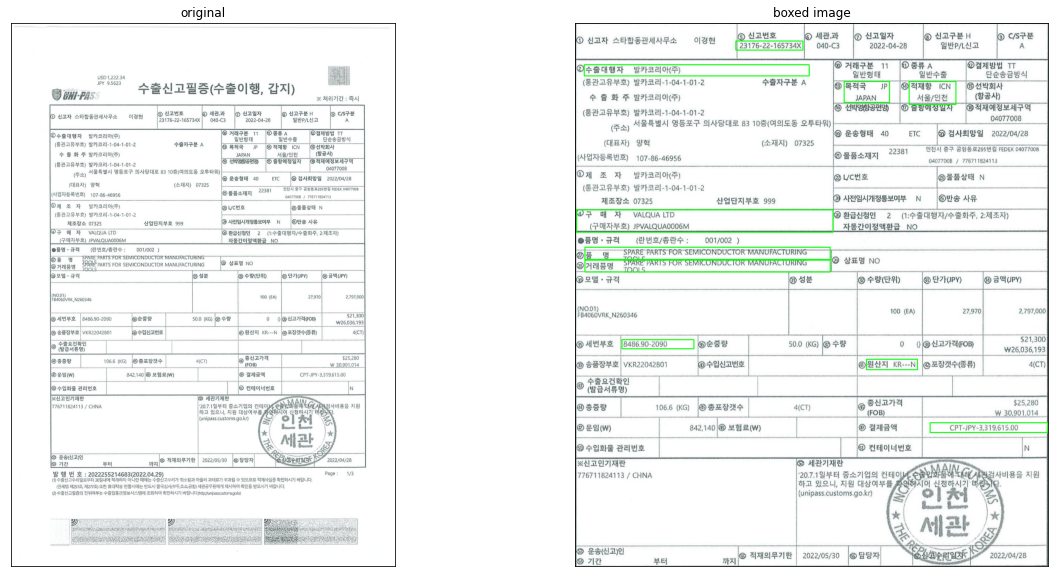

{'ORG_수출신고필증': {'신고번호': '23176-22-165734X', '수출대행자': '수출대행자 발카코리아(주)', '목적국': '목적국 JP JAPAN', '적재항': '적재항 ICN 서원인천', '구매자': '0구 매 자 VALQUA LTD (구매자부로) JPVALQUAOOOGM', '품명': 'SPARE PARTs rOR SEMICONDUCTOR MANUFACTURING TCY기', '거래품명': "거래품명 SFARP ' PARTS FOR SEMICONDUCTOR MANUFACTURING ToOS", '세부번호': '8486,90-2090', '원산지': '민산지 KR-" N', '결제금액': 'CPT-JPY-3,319,615,00'}, 'meta': {'imageSize': {'width': 1354, 'height': 1559}, 'domain': 'drivers_license', 'version': 'v0.3.0', 'ocrToolName': 'Tesseract', 'ocrTool': '4.1.1-rc2-25-g9707', 'language': 'kor+eng', 'annotations': [{'label': '신고번호', 'text': '23176-22-165734X', 'boundingBox': [[460, 54], [652, 54], [652, 80], [460, 80]]}, {'label': '수출대행자', 'text': '수출대행자 발카코리아(주)', 'boundingBox': [[26, 122], [670, 122], [670, 154], [26, 154]]}, {'label': '목적국', 'text': '목적국 JP JAPAN', 'boundingBox': [[770, 170], [900, 170], [900, 230], [770, 230]]}, {'label': '적재항', 'text': '적재항 ICN 서원인천', 'boundingBox': [[956, 170], [1090, 170], [1090, 236], [956, 

In [10]:
image_file = '../output/수출면장-PDF-img24.jpg'
json_file = '../std-json/ORG_export_declaration_certificate.json'
org_image = cv2.imread(image_file)

bboxes, change_image, json_object = recognize_text(image_file, json_file)

draw_image = change_image.copy()
for bounding_box in bboxes:
    cv2.drawContours(draw_image, [bounding_box], -1, (0, 255, 0), 2)

plt_imshow(['original', 'boxed image'], [org_image, draw_image])
print(json_object)

In [ ]:
# custom_config = r'-l kor+eng --psm 6'
custom_config = r'-l kor+eng --psm 4'
text = pytesseract.image_to_string(gray, config=custom_config)

In [ ]:
langs = ['ko', 'en']
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
# results = reader.readtext(change_image)
# results

In [ ]:
simple_results = reader.readtext(change_image, detail = 0, paragraph=True)
simple_results[0]

In [ ]:
simple_results